# **AvStats - Flight Delay Forecast**

*Iraia Torres, October 2024*

This project aims to develop a forecasting model for commercial flight delays. The objective is to analyze historical flight data and investigate how delays are influenced by factors such as flight routes, weather conditions, and passenger volumes. The expected outcome is to generate daily or weekly predictions of flight delays.

The project includes two main Jupyter notebooks that go through data preparation, EDA, and model development.

### **Notebook 1 - Exploratory Data Analysis (EDA)**

This notebook handles the initial stages of data processing and analysis.

1. Data Collection & Preprocessing. Overview of the dataset, handling missing or duplicate values.

2. Feature Engineering. New features for analyzing trends and impacts on delays.

3. External Data
    * Weather data from the meteostat Python library.
    
    * Passenger data from Eurostats.

4. Patterns and Trends
    * Routes Analysis. Common flight routes, routes with the highest delays.
    
    * Weather Impacts. Influence of weather on delays.
                
    * Patterns Across Different Times. Delay patterns by time of day, day of week, month.
      
    * Flight Performance. On-time, delayed, and canceled percentages with variations across routes or seasons

5. Data Transformation
    * Data Encoding. Encoding categorical variables (e.g., route, time window)

    * Data Scaling. Standardizing numerical features using Z-score normalization.

6. Feature Selection with VIF (Variance Inflation Factor). Identifying and addressing multicollinearity in the dataset.


### **1. Data Collection & Processing**

In [1]:
import warnings
from core.DataLoader import save_dataframe, DataLoader
from core.Visualizations import *
from core.EDA.DataProcessing import DataProcessing
from core.EDA.WeatherData import WeatherData
from core.EDA.ColumnsCorrelation import ColumnsCorrelation
from core.EDA.MergeData import MergeData
from core.EDA.PassengerData import PassengerData
from core.EDA.OneHotEncoding import OneHotEncoding
from core.EDA.DataScaling import DataScaling
from core.EDA.Multicollinearity import Multicollinearity
from core.EDA.FlightPerformance import FlightPerformance

In [2]:
data_loader = DataLoader(config_path='config.yaml')
df_avstats, df_passengers, airport_mapping = data_loader.load_data()

if df_avstats is None or df_passengers is None or airport_mapping is None:
    raise SystemExit("Data files are missing or failed to load. Please check your configuration.")

    
##### **Duplicates & Missing Values**

These are the changes made to fill out all the missing values in the dataset.
* Delay minutes NaN -> 0
* Actual departure time (adt) NaN -> Calculate it based on scheduled departure time (sdt) and delay minutes
* Actual arrival time (aat) NaN -> Calculate it based on scheduled arrival time (sat) and delay minutes
* When private flight -> Airline code and flight number as NONE
* Calculate the NaN values for both the calculated scheduled and actual flight time


In [3]:
data_processing = DataProcessing(df_avstats, unique_column='uuid')
df_processed = data_processing.preprocess_avstats()

# Analyze Data Quality
quality_metrics = data_processing.check_missing_and_duplicates(df_processed)
print("Missing Values:", quality_metrics['missing_values'])
print("Duplicate Rows:", quality_metrics['duplicate_rows'])
print("Missing by Column:", quality_metrics['missing_by_column'])

Missing Values: 0
Duplicate Rows: None
Missing by Column: Series([], dtype: int64)


### **2. Feature Engineering**

##### **New Features**

1. Binary column for delays (dep_delay_15): delayed over 15min. (1) or not delayed (0)      
2. Categorize delays (dep_delay_cat): short under 15 min., medium 15 - 60 min. or long over 60 min.
3. Flight category (flight_cat): cargo, commercial, or private.
4. Set dep & arr times into time windows (dep_time_window & arr_time_window):
    * Morning (00:00 to 11:59)
    * Afternoon (12:00 to 17:59)
    * Night (18:00 to 23:59)

In [4]:
df = data_processing.feature_engineering()
negative_dep_delay_rows = df[df['dep_delay'] < 0]
save_dataframe(df, "df_original")
df.head()

DataFrame saved to ..\data\df_original.csv


,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,sdt,adt,arr_iata_code,sat,...,flight_iata_number,calc_sft,calc_aft,calc_flight_distance_km,dep_delay_15,dep_delay_cat,flight_cat,dep_time_window,arr_time_window,on_time_15
0,D4B953A52B6B376A144AFA95DBCF5C14D7154C83,BRU-CPH,ARRIVAL,LANDED,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,...,SK1594,90.0,65.0,754.4,0,Short,Commercial,Afternoon,Afternoon,1
1,476BC61CB63C6766B18F9AF8AF60D3A8F66FF08C,OUD-BRU,ARRIVAL,LANDED,OUD,10.0,2023-08-15 14:00:00+00:00,2023-08-15 14:10:00+00:00,BRU,2023-08-15 16:55:00+00:00,...,AT1688,175.0,153.0,1864.7,0,Short,Commercial,Afternoon,Afternoon,1
2,412CDB45D7CC4CF4C637C50D443E4649773C1787,BRU-CPH,DEPARTURE,ACTIVE,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,...,SK1594,90.0,90.0,754.4,0,Short,Commercial,Afternoon,Afternoon,1
3,01549CD997A261C77CD8CDE664172687D13255BF,IBZ-BRU,ARRIVAL,LANDED,IBZ,23.0,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,BRU,2023-08-15 16:20:00+00:00,...,SN3778,135.0,115.0,1359.5,1,Medium,Commercial,Afternoon,Afternoon,0
4,8CBE8A849C7510077FA66B228920701423E8C976,OTP-BRU,ARRIVAL,SCHEDULED,OTP,90.0,2023-08-15 14:05:00+00:00,2023-08-15 15:34:00+00:00,BRU,2023-08-15 16:55:00+00:00,...,RO373,170.0,171.0,1754.8,1,Long,Commercial,Afternoon,Evening,0


### **3. External Data**

##### **Weather dataframe (meteostat)**

* Create new latitude and longitude (coordinate) columns for both departure and arrival airports
* Fetch weather data based on the route and date
* Handle missing values by dropping flights with missing temperatures and filling the rest with 0

In [5]:
warnings.filterwarnings("ignore", category=UserWarning)
weather_fetcher = WeatherData(df)
weather_fetcher.assign_coordinates().head()
weather_fetcher.fetch_weather_data()
df_weather = weather_fetcher.merge_weather_with_flights()

Assigning coordinates...
Starting weather data fetch for 807 coordinate pairs from 2023-01-01 00:00:00 to 2024-01-01 00:00:00.
Fetched weather for 900 / 807 coordinates.
Fetched weather for 1200 / 807 coordinates.
Fetched weather for 200 / 807 coordinates.
Fetched weather for 600 / 807 coordinates.
Fetched weather for 182600 / 807 coordinates.
Fetched weather for 204400 / 807 coordinates.
Weather data fetching completed with 285304 records.
adt and aat were successfully turned into datetime format.
Weather data was merged with schedule data successfully.


In [6]:
# Remove duplicates and missing values
df_weather = df_weather.drop_duplicates()
df_weather = df_weather.dropna(subset=['tavg_dep', 'tavg_arr'])

# Convert categorical columns to strings and fill missing values
df_weather = df_weather.apply(lambda col: col.astype(str) if col.dtype.name == 'category' else col)
df_weather.fillna(0, inplace=True)

# Preprocess the datetime column
aggregator = MergeData(df_weather)
aggregator.preprocess_datetime()

# Aggregate daily
df_weather_daily = aggregator.aggregate_daily(passenger_data=False)
save_dataframe(df_weather_daily, "df_weather_daily")
df_weather_daily

DataFrame saved to ..\data\df_weather_daily.csv


,route_iata_code,Date,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,...,pres_dep,tsun_dep,tavg_arr,prcp_arr,snow_arr,wdir_arr,wspd_arr,wpgt_arr,pres_arr,tsun_arr
0,AAL-BRU,2023-09-09,5,3,2,1,3,1,576.0,4,...,1016.4,0.0,23.3,0.0,0.0,91.0,4.5,18.5,1017.0,0.0
1,ABJ-BRU,2023-01-01,2,1,1,1,1,0,80.0,2,...,1011.0,0.0,10.1,7.2,0.0,233.0,19.4,44.5,1017.1,0.0
2,ABJ-BRU,2023-01-04,2,1,1,1,1,0,72.0,2,...,1011.4,0.0,11.0,1.1,0.0,244.0,20.4,46.3,1021.0,0.0
3,ABJ-BRU,2023-01-06,2,1,1,1,1,0,88.0,2,...,1012.0,0.0,10.3,0.1,0.0,194.0,24.3,46.3,1010.4,0.0
4,ABJ-BRU,2023-01-08,2,1,1,1,1,0,48.0,2,...,1011.7,0.0,6.7,0.5,0.0,237.0,23.0,46.3,1000.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74933,ZTH-BRU,2023-10-14,2,1,1,1,1,0,18.0,0,...,1016.9,0.0,12.1,4.2,0.0,259.0,20.7,48.2,1013.2,0.0
74934,ZTH-BRU,2023-10-15,2,1,1,1,1,0,34.0,2,...,1013.1,0.0,8.3,1.1,0.0,258.0,13.1,29.6,1022.7,0.0
74935,ZTH-BRU,2023-10-21,2,1,1,1,1,0,32.0,2,...,1015.0,0.0,13.4,0.9,0.0,190.0,24.0,51.8,990.2,0.0
74936,ZTH-BRU,2023-10-22,2,1,1,1,1,0,24.0,0,...,1015.8,0.0,12.6,2.9,0.0,219.0,15.0,51.8,1005.6,0.0


##### **Passenger dataframe (Eurostats)**

Air passenger based on partner airports and the BRU International Airport routes (ec.europa.eu).

In [7]:
passengers = PassengerData(df_passengers, airport_mapping)
df_passengers_cleaned = passengers.process_passenger_data()

# Aggregate monthly (to include passengers)
aggregator.aggregate_daily(passenger_data=True)
df_passengers_monthly = aggregator.aggregate_passengers(df_passengers_cleaned)

df_passengers_monthly

,route_iata_code,Month,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,...,total_tsun_dep,avg_tavg_arr,total_prcp_arr,avg_snow_arr,avg_wdir_arr,avg_wspd_arr,avg_wpgt_arr,avg_pres_arr,total_tsun_arr,total_passengers
0,BRU-ACC,2023-01,42,21,21,18,21,3,1529.0,36,...,0.0,28.604762,9.5,0.000000,219.404762,12.921429,0.000000,1010.616667,0.0,10006
1,BRU-ACC,2023-02,35,19,16,14,19,2,1206.0,25,...,0.0,29.265714,10.5,0.000000,199.257143,13.960000,0.000000,1009.900000,0.0,8645
2,BRU-ACC,2023-03,46,22,24,17,22,7,1544.0,37,...,0.0,28.656522,55.6,0.000000,220.304348,13.467391,0.000000,1010.054348,0.0,10371
3,BRU-ACC,2023-04,37,18,19,15,18,4,1380.0,32,...,0.0,29.067568,62.9,0.000000,224.189189,14.245946,0.000000,1009.391892,0.0,11042
4,BRU-ACC,2023-05,39,18,21,17,18,2,1624.0,37,...,0.0,28.769231,165.4,0.000000,220.615385,11.605128,0.000000,1011.353846,0.0,10879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,BRU-ZRH,2023-08,222,109,113,87,109,26,8083.0,165,...,0.0,20.059459,946.6,0.000000,243.121622,7.890991,35.017117,1015.321622,0.0,25871
752,BRU-ZRH,2023-09,246,120,126,108,120,18,7941.0,177,...,0.0,17.932927,300.0,0.000000,236.792683,6.567073,28.096748,1017.884959,0.0,27551
753,BRU-ZRH,2023-10,270,135,135,130,135,5,6782.0,170,...,0.0,12.486667,558.7,0.000000,245.011111,8.712963,33.300741,1014.055926,0.0,27995
754,BRU-ZRH,2023-11,266,131,135,133,131,2,6157.0,158,...,0.0,6.135338,1646.5,1.353383,225.436090,11.951880,45.408271,1012.524060,0.0,26911


### **4. Patterns and Trends**

##### **Approach**

1. What is the main reason for delays?
2. What are the most common flight routes in the dataset?
3. Which routes experience the highest delays?
4. How does weather impact departure and arrival delays?
5. Are there patterns in delays across different times of the day, week, or month?
6. What percentage of flights are on time, delayed, or canceled?

##### **Explanation of Different Dataframes**

* Meaning of the different dataframes used through the exploratory data analysis.
* df. Original 2023 flight schedule dataset with cleaned data | 340k rows; one for each flight
* df_weather. Same but with the weather conditions for departure and arrival airports | 332k rows; one for each flight
* df_weather_daily. Flights are grouped daily per route | 75k rows; one for each day per route (used to be df_weather)
* df_passengers_monthly. Flights are grouped monthly per route | 756 rows; one per month per route (used to be df_merged)

#### **4.1. Correlation heatmaps for numerical and categorical columns**

* Numerical Columns:.corr()
* Categorical Columns: Cramér's V (Statistical measure)

In statistics, Cramér's V is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic 

In [8]:
#df_sample = df.sample(n=10000, random_state=42) # Use a smaller subset of rows
#correlation = ColumnsCorrelation(df_sample)
#correlation.plot_correlation_heatmaps()

#### **4.1. Characteristics of delayed flights**

It compares the average delays across categories such as time and routes.

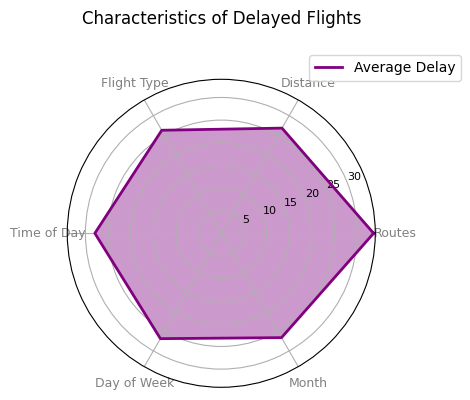

In [9]:
plot_radar_chart(df)

#### **4.2. Routes Analysis**

Most common routes and routes with the highest delays.

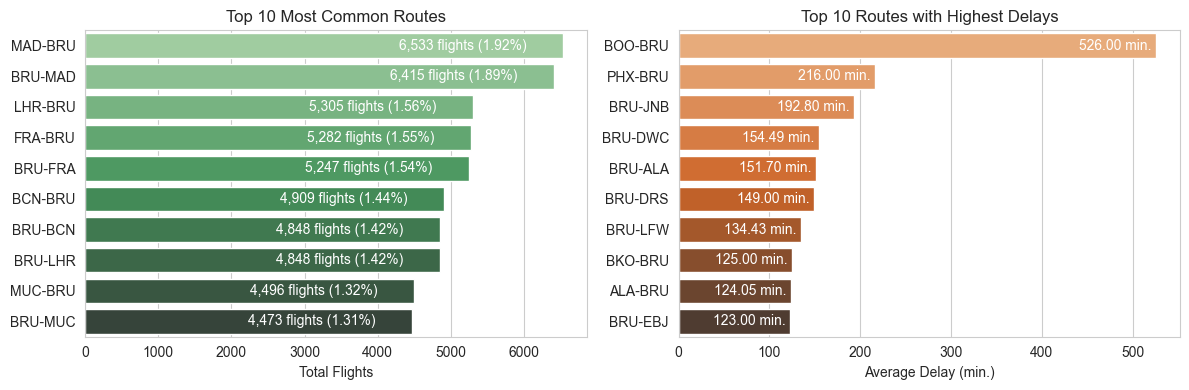

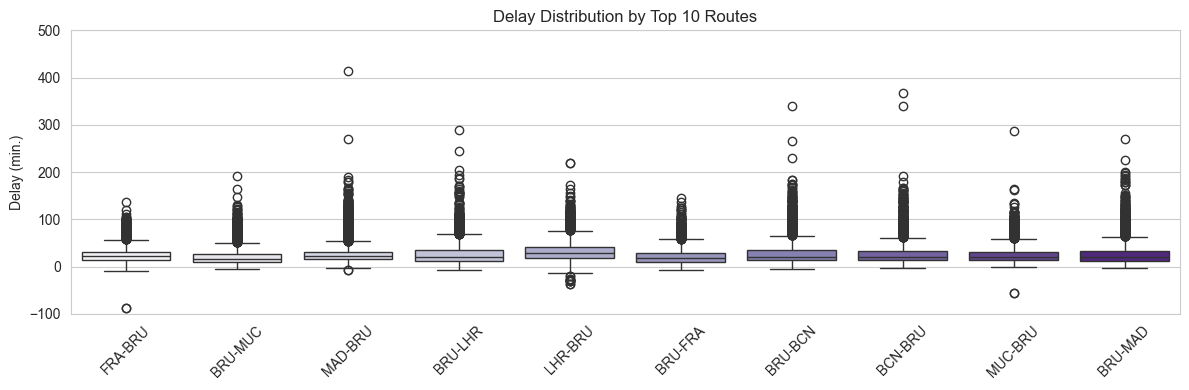

In [10]:
plot_route_analysis(df=df, route_column='route_iata_code', delay_column='dep_delay', top_n=10)

#### **4.3. Weather Impact**

Analysis of precipitation effects on departure delays.

Distribution of Precipitation Levels:
precipitation_level
No Precipitation    173122
Light Rain          135867
Moderate Rain        22083
Heavy Rain            1191
Name: count, dtype: int64


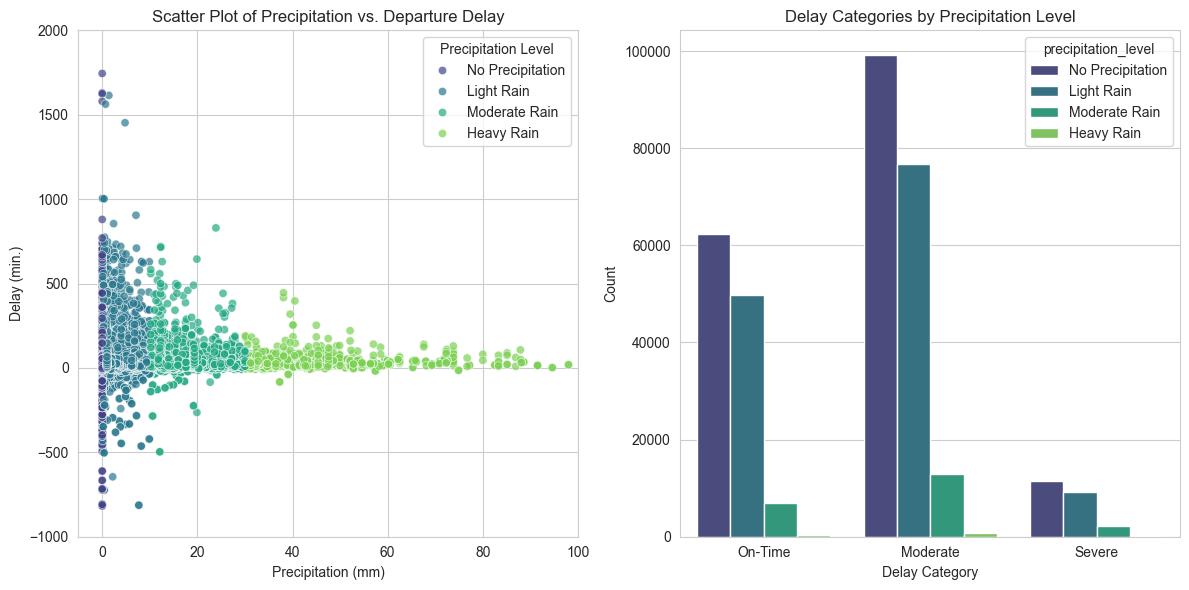

In [11]:
plot_precipitation_impact(df_weather=df_weather, precipitation_column='prcp_dep', delay_column='dep_delay')

#### **4.4. Patterns Across Different Times**

Delay patterns by time of day, day of week, or month.

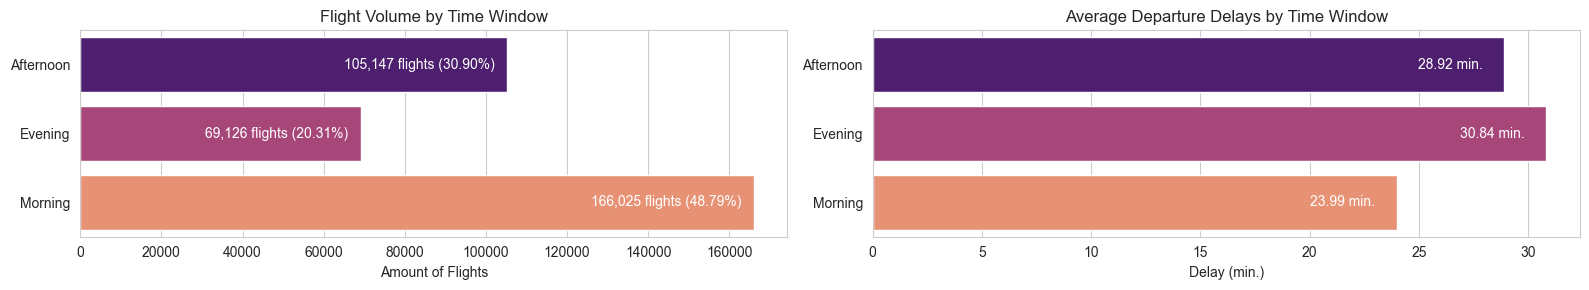

In [12]:
plot_time_window(df=df,time_window_column='dep_time_window', delay_column='dep_delay', volume_palette='magma',delay_palette='magma')

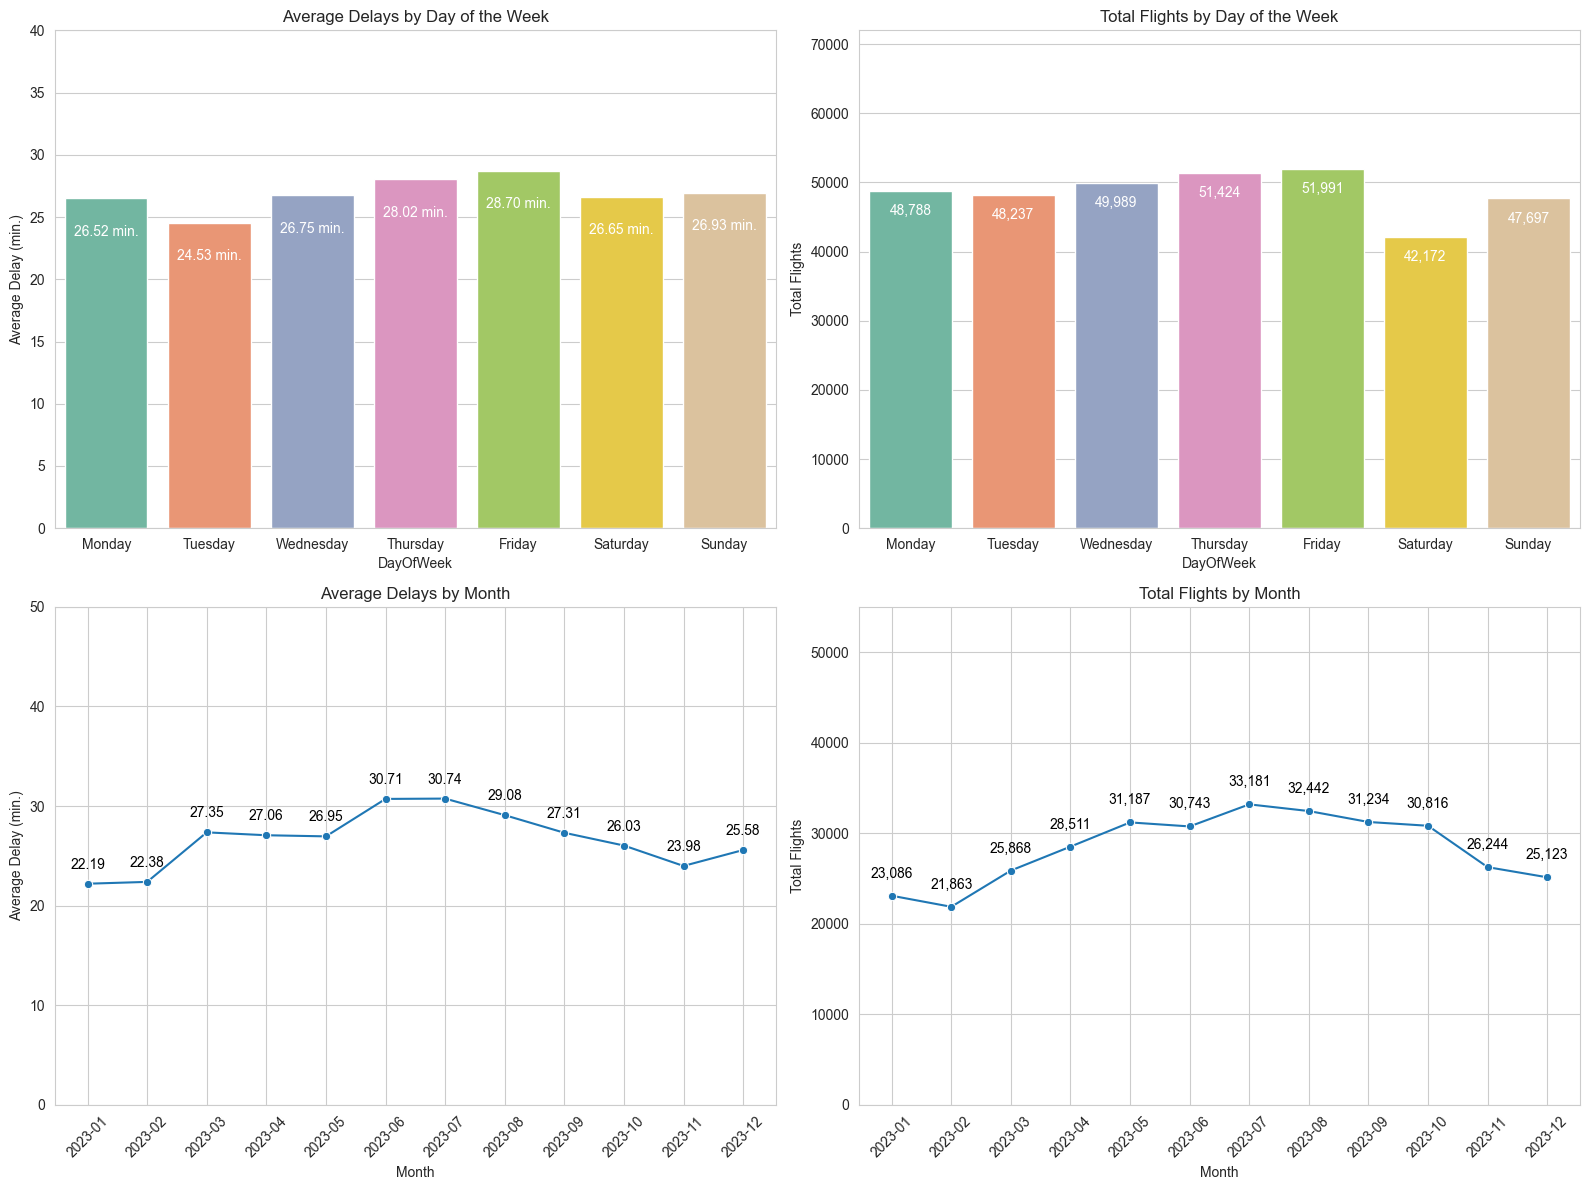

In [13]:
# Assuming df is your main DataFrame
plot_weekly_and_monthly_comparison(df, day_column='sdt', delay_column='dep_delay', palette='Set2')

#### **4.5. Flight Performance**

On-time, delayed, and canceled percentages, along with variations by route or season.

Overall Flight Performance Percentage:
Delayed Flights (%): 64.05%
On-Time Flights (%): 32.31%
Missing Status (%): 3.64%


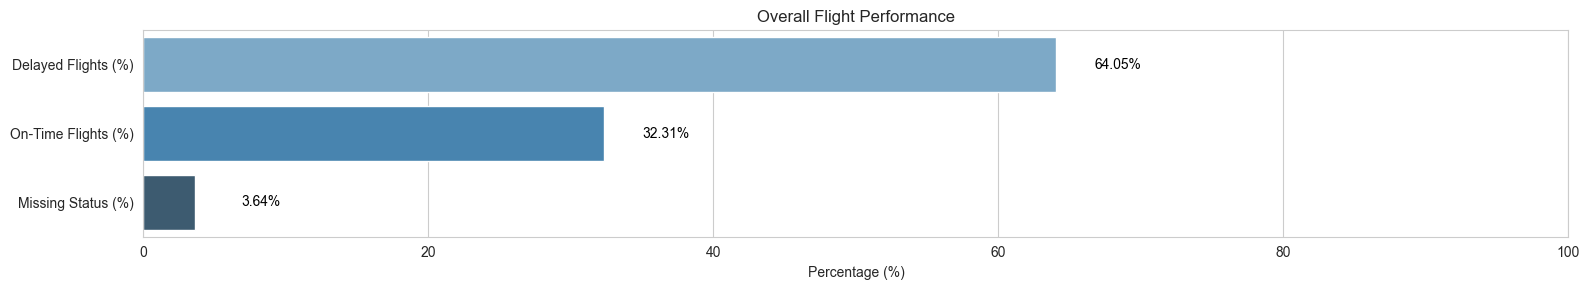

In [14]:
flight_performance = FlightPerformance(df)
performance_metrics = flight_performance.overall_performance()

print("Overall Flight Performance Percentage:")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.2f}%")

plot_overall_performance(performance_metrics)

### **5. Data Transformation**

##### **Explanation of Different Dataframes**

* Meaning of the different dataframes used through the exploratory data analysis.
* df. Original 2023 flight schedule dataset with cleaned data | 340k rows; one for each flight
* df_weather. Same but with the weather conditions for departure and arrival airports | 332k rows; one for each flight
* df_weather_daily. Flights are grouped daily per route | 75k rows; one for each day per route (used to be df_weather)
* df_passengers_monthly. Flights are grouped monthly per route | 756 rows; one per month per route (used to be df_merged)

#### **5.1. Data Encoding**

Encoding categorical variables (e.g., route, time window).


**Preparing dataframe for Time-series Models** (ARIMA, SARIMAX, Rolling Forecast)
* **df_BRU_MAD**. Same as *df_weather_daily* but encoded and with just 1 route | **364 rows**; one per day

In [15]:
# Encode original data
data_encoding_original= OneHotEncoding(df)
df_encoded_original = data_encoding_original.encode_routes()
df_numeric_original, df_cleaned_original = data_encoding_original.clean_data()

# Encode weather data 
df_weather_daily['total_dep_delay_15'] = df_weather_daily['total_dep_delay_15'].astype('int64')
df_weather_daily['total_on_time_15'] = df_weather_daily['total_on_time_15'].astype('int64')
data_encoding_weather = OneHotEncoding(df_weather_daily)
df_encoded_weather = data_encoding_weather.encode_routes()
df_numeric_weather, df_cleaned_weather = data_encoding_weather.clean_data()

# Encode single route (e.g. BRU-MAD) (ARIMA, SARIMAX, and Rolling Forecast)
df_BRU_MAD = df_weather_daily[df_weather_daily['route_iata_code'] == 'BRU-MAD']
data_encoding_BRU_MAD = OneHotEncoding(df_BRU_MAD)
df_encoded_BRU_MAD = data_encoding_BRU_MAD.encode_routes()
df_numeric_BRU_MAD, df_cleaned_BRU_MAD = data_encoding_BRU_MAD.clean_data()
"""
df_weather_encoded['BRU-MAD'] = pd.to_numeric(df_weather_encoded['BRU-MAD'], errors='coerce')
df_BRU_MAD = df_weather_encoded[df_weather_encoded['BRU-MAD'] == 2]
save_dataframe(df_BRU_MAD, "df_BRU_MAD")
df_weather_encoded"""

'\ndf_weather_encoded[\'BRU-MAD\'] = pd.to_numeric(df_weather_encoded[\'BRU-MAD\'], errors=\'coerce\')\ndf_BRU_MAD = df_weather_encoded[df_weather_encoded[\'BRU-MAD\'] == 2]\nsave_dataframe(df_BRU_MAD, "df_BRU_MAD")\ndf_weather_encoded'

In [16]:
df_weather_daily

,route_iata_code,Date,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,...,pres_dep,tsun_dep,tavg_arr,prcp_arr,snow_arr,wdir_arr,wspd_arr,wpgt_arr,pres_arr,tsun_arr
0,AAL-BRU,2023-09-09,5,3,2,1,3,1,576.0,4,...,1016.4,0.0,23.3,0.0,0.0,91.0,4.5,18.5,1017.0,0.0
1,ABJ-BRU,2023-01-01,2,1,1,1,1,0,80.0,2,...,1011.0,0.0,10.1,7.2,0.0,233.0,19.4,44.5,1017.1,0.0
2,ABJ-BRU,2023-01-04,2,1,1,1,1,0,72.0,2,...,1011.4,0.0,11.0,1.1,0.0,244.0,20.4,46.3,1021.0,0.0
3,ABJ-BRU,2023-01-06,2,1,1,1,1,0,88.0,2,...,1012.0,0.0,10.3,0.1,0.0,194.0,24.3,46.3,1010.4,0.0
4,ABJ-BRU,2023-01-08,2,1,1,1,1,0,48.0,2,...,1011.7,0.0,6.7,0.5,0.0,237.0,23.0,46.3,1000.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74933,ZTH-BRU,2023-10-14,2,1,1,1,1,0,18.0,0,...,1016.9,0.0,12.1,4.2,0.0,259.0,20.7,48.2,1013.2,0.0
74934,ZTH-BRU,2023-10-15,2,1,1,1,1,0,34.0,2,...,1013.1,0.0,8.3,1.1,0.0,258.0,13.1,29.6,1022.7,0.0
74935,ZTH-BRU,2023-10-21,2,1,1,1,1,0,32.0,2,...,1015.0,0.0,13.4,0.9,0.0,190.0,24.0,51.8,990.2,0.0
74936,ZTH-BRU,2023-10-22,2,1,1,1,1,0,24.0,0,...,1015.8,0.0,12.6,2.9,0.0,219.0,15.0,51.8,1005.6,0.0


**Preparing dataframe for ML Models** (Linear Regression, Decision Tree, Random Forest)
* **df_passengers_numeric**. Same as *df_passengers_monthly* but encoded | **756 rows**; one per month per route

**Ready for ML:**
* **df_passengers_vif**. Same as *df_passengers_numeric* after feature selection | **756 rows**; one per month per route

In [17]:
df_passengers_monthly['Month'] = df_passengers_monthly['Month'].astype(str) # Convert to string
df_passengers_monthly['total_dep_delay_15'] = df_passengers_monthly['total_dep_delay_15'].astype('int64')
df_passengers_monthly['total_on_time_15'] = df_passengers_monthly['total_on_time_15'].astype('int64')

# Encode the routes and clean data by removing columns
data_encoding_passengers = OneHotEncoding(df_passengers_monthly)
df_encoded_passengers = data_encoding_passengers.encode_routes()
df_numeric_passengers, df_cleaned_passengers = data_encoding_passengers.clean_data()
df_numeric_passengers

,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,total_on_time_15,short_delay,...,BRU-TLS,BRU-TLV,BRU-TNG,BRU-TUN,BRU-VCE,BRU-VIE,BRU-VLC,BRU-WAW,BRU-YUL,BRU-ZRH
0,42,21,21,18,21,3,1529.0,36,2,6,...,0,0,0,0,0,0,0,0,0,0
1,35,19,16,14,19,2,1206.0,25,7,10,...,0,0,0,0,0,0,0,0,0,0
2,46,22,24,17,22,7,1544.0,37,8,9,...,0,0,0,0,0,0,0,0,0,0
3,37,18,19,15,18,4,1380.0,32,5,5,...,0,0,0,0,0,0,0,0,0,0
4,39,18,21,17,18,2,1624.0,37,2,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,222,109,113,87,109,26,8083.0,165,44,57,...,0,0,0,0,0,0,0,0,0,2
752,246,120,126,108,120,18,7941.0,177,67,69,...,0,0,0,0,0,0,0,0,0,2
753,270,135,135,130,135,5,6782.0,170,80,100,...,0,0,0,0,0,0,0,0,0,2
754,266,131,135,133,131,2,6157.0,158,104,108,...,0,0,0,0,0,0,0,0,0,2


Correlation analysis helps you understand the relationships between numerical variables. This can inform feature selection, detect multicollinearity, and reveal underlying patterns in the data.
* **Positive correlation with delays**: More likely to experience delays. A high positive correlation indicates that delays are more frequent on that route.
* **Negative correlation with delays**: Less likely to be delayed. These routes tend to run on time, indicating more consistent operational conditions or favorable factors.

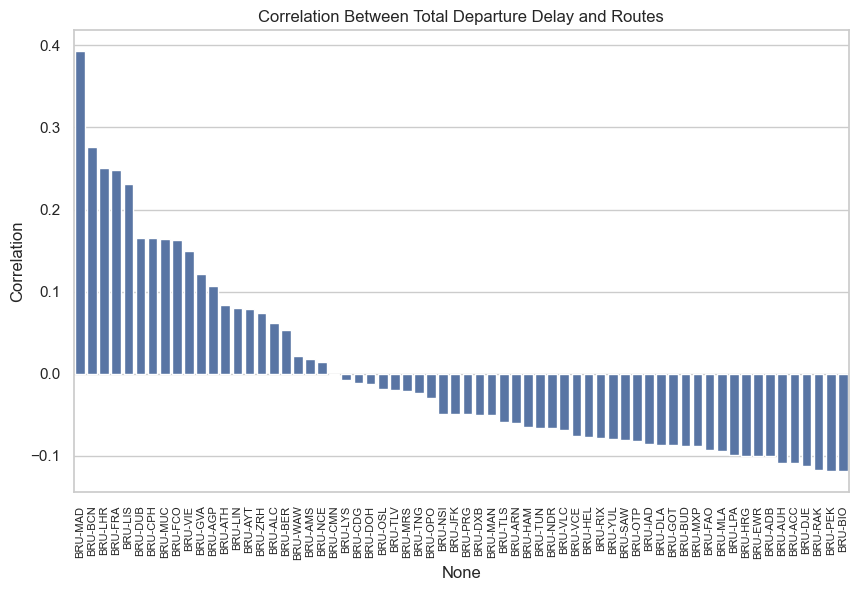

Routes showing the strongest positive correlation with Departure Delays:
 BRU-MAD    0.392701
BRU-BCN    0.275766
BRU-LHR    0.250346
BRU-FRA    0.248473
BRU-LIS    0.231481
Name: total_dep_delay_15, dtype: float64


In [18]:
# Select the route code columns and the target column
route_columns = [col for col in df_encoded_passengers.columns if '-' in col]
corr_columns = ['total_dep_delay_15'] + route_columns

# Extract only the correlation of 'total_dep_delay' with the routes
correlation_matrix = df_encoded_passengers[corr_columns].corr()
total_dep_delay_corr = correlation_matrix['total_dep_delay_15'][route_columns].sort_values(ascending=False)

# Filter for only positive correlations
positive_corr = total_dep_delay_corr[total_dep_delay_corr > 0.2]

# Plot the correlation between total_dep_delay and the route codes
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=total_dep_delay_corr.index, y=total_dep_delay_corr.values)
plt.xticks(rotation=90, fontsize=8)
plt.title('Correlation Between Total Departure Delay and Routes', fontsize=12)
plt.ylabel('Correlation')
plt.show()

# Print correlation values for better inspection
print('Routes showing the strongest positive correlation with Departure Delays:\n',positive_corr)

#### **5.2. Data Scaling**

##### **Standardization - Z-score normalization**

**Purpose**: To scale features so that they have a mean of 0 and a standard deviation of 1, effectively transforming the data to a standard normal distribution.

**How it works**: The formula for standardization is:

    Xstd = (X − μ) / σ

where:

    X is the feature value,
    μ is the mean of the feature,
    σ is the standard deviation of the feature.

**When to use**:
* When the data follows a normal distribution (or approximately) or when  working with algorithms that assume data is normally distributed, like linear regression, logistic regression, or principal component analysis (PCA).
* It is less sensitive to outliers than normalization but still can be affected if there are extreme outliers.

**Interpretation**:
* Means close to 0: The means are extremely close to zero, indicated by very small values like 7.518971e-17, which is essentially 0.
* Standard Deviations close to 1: The standard deviations are approximately 1 (1.000662), which confirms that all features have been scaled to a unit standard deviation.

In [19]:
# Standardize original data
data_prep_original = DataScaling(df_numeric_original, 'dep_delay')
df_scaled_original, target_variable_original = data_prep_original.standardize_data()

# Standardize weather data
data_prep_weather = DataScaling(df_numeric_weather, 'total_dep_delay')
df_scaled_weather, target_variable_weather = data_prep_weather.standardize_data()  

# Standardize single route
data_prep_BRU_MAD = DataScaling(df_numeric_BRU_MAD, 'total_dep_delay')
df_scaled_BRU_MAD, target_variable_BRU_MAD = data_prep_BRU_MAD.standardize_data()  

# Standardize passenger data
data_prep_passengers = DataScaling(df_numeric_passengers, 'total_dep_delay')
df_scaled_passengers, target_variable_passengers = data_prep_passengers.standardize_data()

# Check the mean and standard deviation
print("Means of scaled features:\n", df_scaled_passengers.mean())
print("Standard deviations of scaled features:\n", df_scaled_passengers.std())

Means of scaled features:
 total_flights   -1.080852e-16
departures      -1.409807e-17
arrivals         1.879743e-17
landed           7.518971e-17
active           4.934325e-17
                     ...     
BRU-VIE          9.398713e-18
BRU-VLC          9.398713e-18
BRU-WAW          9.398713e-18
BRU-YUL          9.398713e-18
BRU-ZRH         -2.819614e-17
Length: 102, dtype: float64
Standard deviations of scaled features:
 total_flights    1.000662
departures       1.000662
arrivals         1.000662
landed           1.000662
active           1.000662
                   ...   
BRU-VIE          1.000662
BRU-VLC          1.000662
BRU-WAW          1.000662
BRU-YUL          1.000662
BRU-ZRH          1.000662
Length: 102, dtype: float64


In [20]:
df_scaled_passengers

,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay_15,total_on_time_15,short_delay,medium_delay,...,BRU-TLS,BRU-TLV,BRU-TNG,BRU-TUN,BRU-VCE,BRU-VIE,BRU-VLC,BRU-WAW,BRU-YUL,BRU-ZRH
0,-1.020906,-1.017989,-1.023053,-1.011953,-1.027484,-0.457786,-0.880541,-1.057330,-1.008000,-0.892910,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
1,-1.079034,-1.051632,-1.104999,-1.081155,-1.061006,-0.606705,-1.019600,-0.954226,-0.932334,-1.033415,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
2,-0.987690,-1.001168,-0.973885,-1.029254,-1.010723,0.137887,-0.867899,-0.933606,-0.951250,-0.892910,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
3,-1.062426,-1.068453,-1.055831,-1.063854,-1.077767,-0.308868,-0.931108,-0.995468,-1.026916,-0.921011,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
4,-1.045818,-1.068453,-1.023053,-1.029254,-1.077767,-0.606705,-0.867899,-1.057330,-1.083665,-0.906961,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,0.473826,0.462269,0.484764,0.181768,0.447464,2.967337,0.750244,-0.191260,-0.043263,0.413782,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008
752,0.673124,0.647302,0.697825,0.545074,0.631832,1.775990,0.901945,0.283017,0.183734,0.722892,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008
753,0.872421,0.899619,0.845328,0.925681,0.883244,-0.159949,0.813453,0.551086,0.770143,0.933649,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008
754,0.839205,0.832334,0.845328,0.977582,0.816201,-0.606705,0.661752,1.045983,0.921475,0.765044,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008


### **6. Feature Selection with Variance Inflation Factor**

#### **6.1. Regularization - Lasso**

**Purpose**: To prevent overfitting by adding a penalty to the loss function of the model, effectively discouraging the model from becoming too complex.

**How it works**:
* **L1 regularization (Lasso)**: Adds a penalty term proportional to the absolute value of the coefficients. It can drive some coefficients to zero, effectively performing feature selection.
* **L2 regularization (Ridge)**: Adds a penalty term proportional to the square of the coefficients, encouraging smaller coefficients but not necessarily driving them to zero.
* **ElasticNet** combines both L1 and L2 penalties.

**When to use**:
* When the model is overfitting, meaning it performs well on training data but poorly on test data.
* It is used to constrain the complexity of a model, especially when there are too many features or when there’s a risk of multicollinearity.

**Interpretation**:
* The coefficient indicates the strength of the relationship between the feature and the target variable. 
* The higher the absolute value, the more influence that feature has on the target.
* Example **landed: 1600.493731**: This suggests that landed has a strong positive influence on the target variable (total_dep_delay). As the value of landed increases, the predicted value of total_dep_delay is likely to increase by approximately 1600 minutes.

Important features according to Lasso regression: total_dep_delay_15    1400.578947
total_flights          929.157372
long_delay             729.771380
landed                 208.641175
scheduled              168.281532
evening_arr            163.094221
morning_dep             99.189685
arrivals                76.540713
total_calc_sft          66.243498
avg_wpgt_dep            63.745324
BRU-AMS                 43.615242
avg_tavg_arr           -43.827618
afternoon_dep          -46.546696
BRU-IAD                -51.632644
BRU-PEK                -57.859869
cargo                  -76.023090
avg_wpgt_arr          -111.514176
avg_wspd_dep          -112.064819
total_on_time_15      -113.512697
short_delay           -189.418403
dtype: float64


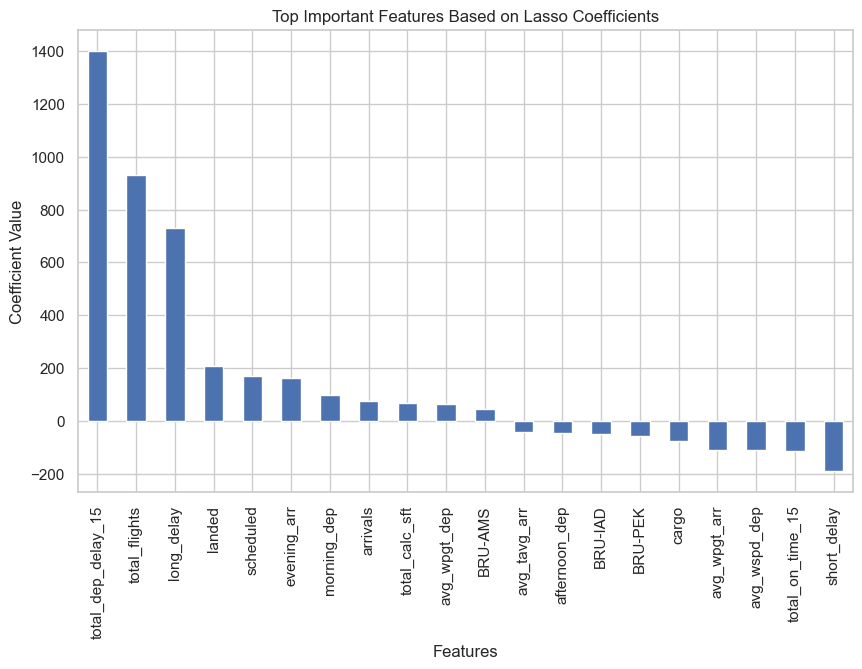

In [21]:
important_features_df, important_features = data_prep_passengers.select_important_features()
important_features_df_weather, important_features_weather = data_prep_weather.select_important_features()

# The important features
print(f"Important features according to Lasso regression: {important_features}")

# Visualize the top 10 important features
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar')
plt.title('Top Important Features Based on Lasso Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

#### **6.2. Multicollinearity - VIF**

The target variable should be kept in the DataFrame after the VIF process but excluded from the calculations when identifying features with high multicollinearity since the target variable is needed for the modeling stage.

In [23]:
# Remove features with high VIF values
#multicollinearity_original = Multicollinearity(df_scaled_original, target_variable_original)
#df_vif_original, final_features_original, vif_data_original = multicollinearity_original.remove_high_vif_features()
#save_dataframe(df_vif_original, "df_vif_original")

KeyboardInterrupt: 

In [25]:
# Remove features with high VIF values for weather data
df_scaled_weather_few = df_scaled_weather.iloc[:, :39]
multicollinearity_weather = Multicollinearity(df_scaled_weather_few, target_variable_weather)
df_vif_weather, final_features_weather, vif_data_weather = multicollinearity_weather.remove_high_vif_features()
save_dataframe(df_vif_weather, "df_vif_weather")

# Remove features with high VIF values for single route data
multicollinearity_BRU_MAD = Multicollinearity(df_scaled_BRU_MAD, target_variable_BRU_MAD)
df_vif_BRU_MAD, final_features_BRU_MAD, vif_data_BRU_MAD = multicollinearity_BRU_MAD.remove_high_vif_features()
save_dataframe(df_vif_BRU_MAD, "df_vif_BRU_MAD")

# Remove features with high VIF values for passenger data
multicollinearity_passengers = Multicollinearity(df_scaled_passengers, target_variable_passengers)
df_vif_passengers, final_features_passengers, vif_data_passengers = multicollinearity_passengers.remove_high_vif_features()
save_dataframe(df_vif_passengers, "df_vif_passengers")

DataFrame saved to ..\data\df_vif_weather.csv


DataFrame saved to ..\data\df_vif_BRU_MAD.csv


DataFrame saved to ..\data\df_vif_passengers.csv


In [26]:
vif_data_weather

,feature,VIF
0,landed,2.01
1,scheduled,2.22
2,total_on_time_15,1.65
3,long_delay,2.23
4,total_flight_distance_km,1.45
5,cargo,1.05
6,tavg_dep,1.68
7,prcp_dep,1.05
8,snow_dep,1.04
9,wdir_dep,1.04


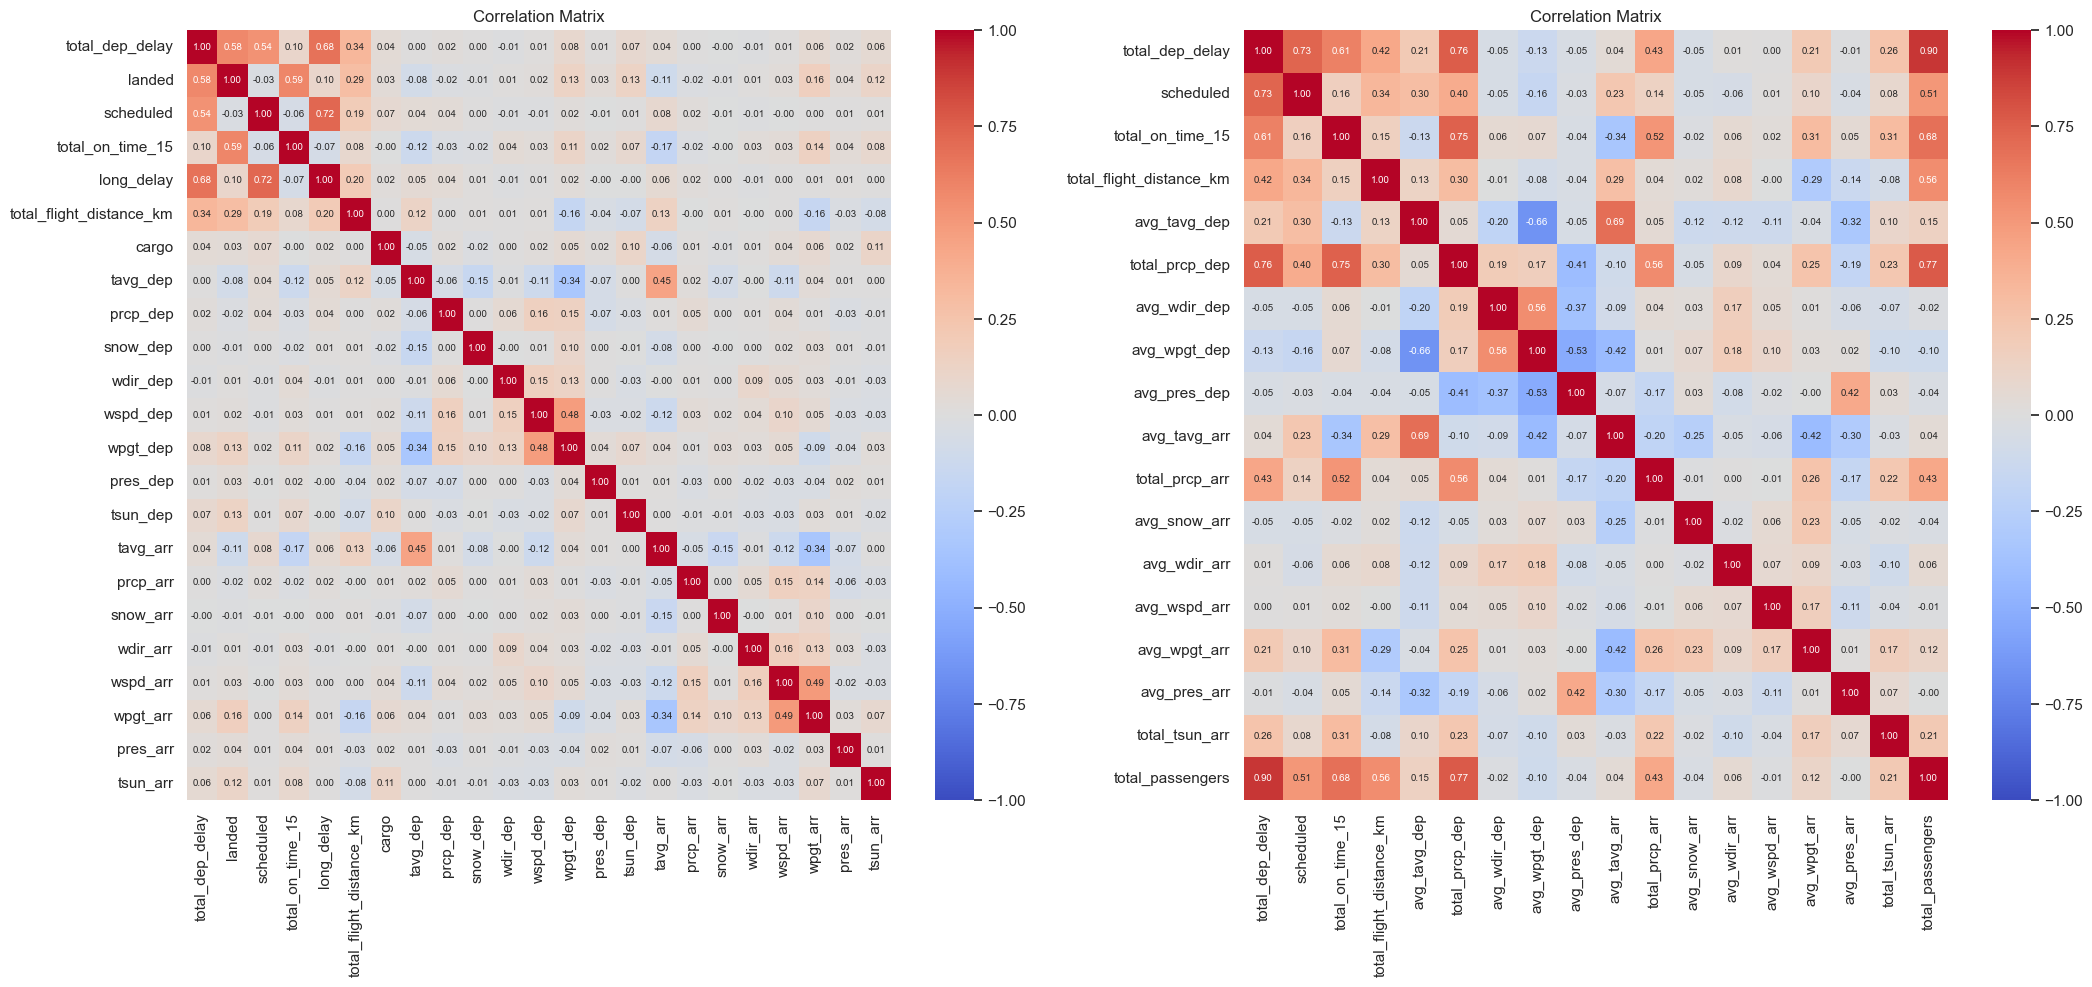

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10)) 

# Plot heatmap before VIF removal
correlation_matrix_features = df_vif_weather.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_features, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[0], vmin=-1, vmax=1, annot_kws={"size": 7}) 
axes[0].set_title('Correlation Matrix')

# Plot heatmap after VIF removal
correlation_matrix_vif = df_vif_passengers.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_vif, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1, annot_kws={"size": 7}) 
axes[1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()